## Aggregation / Downscaling data simulation experiment. 

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree
from sklearn.neighbors import NearestNeighbors
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float_kind': '{:f}'.format})


family = Gaussian()

### Simulate Data

### Aggregation

#### Point to Polygon Change of Support (the polygon is the target support)

I have used the the census tracts in PG county, Maryland, to represent polygon spatial support. I then randomly assigned median income value to each census tract in PG county

In [2]:
md = gpd.read_file("tl_rd22_24_tract.zip") # Census tracts for the state of maryland

pg = md[md['COUNTYFP']=='033'].copy().reset_index(drop=True)  # Extract all the cesus tracts in PG county

pg['median_income'] = np.random.randint(30000, 150001, size=len(pg)) # Randomly assign values between 30k and 150k 

pg_county = pg[['median_income', 'geometry']].copy() 

For points I randomly generated points using the total bounds for PG county

In [3]:
points = []

minx, miny, maxx, maxy = pg_county.total_bounds
np.random.seed(85)
points = [Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)) for _ in range(1500)]
p_gdf = gpd.GeoDataFrame(geometry=points, crs=pg_county.crs)

In [4]:
np.random.seed(85)
p_gdf['count'] = np.random.randint(1, 6, size=len(p_gdf))
p_gdf

,geometry,count
0,POINT (-76.82777 38.83870),3
1,POINT (-76.96206 38.92502),1
2,POINT (-76.97237 38.84715),5
3,POINT (-76.93079 38.75546),4
4,POINT (-76.78011 38.92195),5
...,...,...
1495,POINT (-76.90494 39.05638),1
1496,POINT (-76.87709 38.58299),4
1497,POINT (-76.73671 38.63032),5
1498,POINT (-76.76716 38.90145),3


<Axes: >

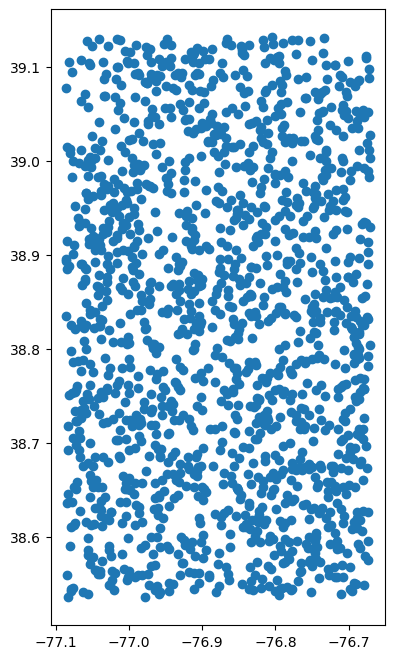

In [5]:
p_gdf.plot(figsize=(5, 8))

#### Clip >>> Spatial Join >>> Aggregate

I then clip the points the extents of the polygon. The goal is to then perform a spatial join of these points to the polygon and then aggregate the mean or sum of the points in each census tract. 

In [6]:
external_boundary = pg_county.unary_union  # Combine all polygons into a single boundary
clipped_pg = p_gdf[p_gdf.intersects(external_boundary)]  # Clip points

In [7]:
clipped_pg

,geometry,count
0,POINT (-76.82777 38.83870),3
3,POINT (-76.93079 38.75546),4
4,POINT (-76.78011 38.92195),5
5,POINT (-76.70045 38.67075),4
6,POINT (-76.91733 39.06203),3
...,...,...
1493,POINT (-76.90809 38.95287),2
1494,POINT (-76.70212 38.94567),3
1495,POINT (-76.90494 39.05638),1
1497,POINT (-76.73671 38.63032),5


In [8]:
clipped_pg.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

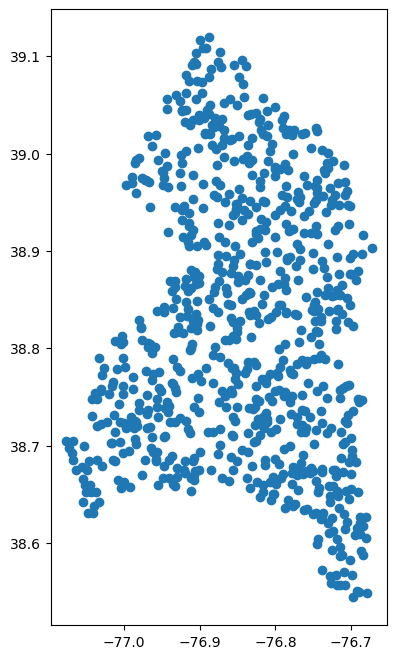

In [9]:
clipped_pg.plot(figsize=(5, 8))

### Spatial Join and Aggregate (Naive way) 

In [10]:
joined = gpd.sjoin(clipped_pg, pg_county, how='inner', predicate='within')

In [11]:
joined

,geometry,count,index_right,median_income
0,POINT (-76.82777 38.83870),3,59,103155
12,POINT (-76.78658 38.83634),1,59,103155
363,POINT (-76.83854 38.85489),1,59,103155
442,POINT (-76.83532 38.83769),4,59,103155
463,POINT (-76.84607 38.82754),5,59,103155
...,...,...,...,...
1319,POINT (-76.94233 39.04617),1,213,123043
1342,POINT (-76.82499 38.76158),5,183,38862
1359,POINT (-76.96503 38.94548),5,76,92757
1377,POINT (-76.94687 38.84201),5,8,121676


<Axes: >

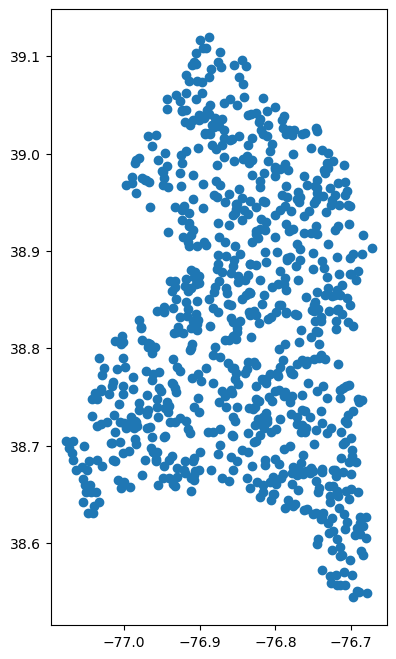

In [12]:
joined.plot(figsize=(5, 8))

In [13]:
aggregated = joined.groupby('index_right').agg({'count': ['sum', 'mean']}).reset_index()

In [14]:
aggregated.columns = ['index_right', 'sum_count_values', 'mean_count_values']

In [15]:
aggregated

,index_right,sum_count_values,mean_count_values
0,0,9,3.000000
1,1,19,2.714286
2,2,3,3.000000
3,3,17,2.833333
4,5,3,1.500000
...,...,...,...
150,207,3,3.000000
151,209,1,1.000000
152,210,3,3.000000
153,212,3,3.000000


In [16]:
pg_county_agg = pg_county.merge(aggregated, left_index=True, right_on='index_right', how='left').reset_index(drop=True)

In [17]:
pg_county_agg

,median_income,geometry,index_right,sum_count_values,mean_count_values
0,108970,"POLYGON ((-76.99329 38.75592, -76.99312 38.755...",0,9.0,3.000000
1,133154,"POLYGON ((-76.86738 38.77593, -76.86727 38.775...",1,19.0,2.714286
2,81762,"POLYGON ((-76.91869 38.76704, -76.91824 38.767...",2,3.0,3.000000
3,51737,"POLYGON ((-76.94209 38.75874, -76.94183 38.758...",3,17.0,2.833333
4,62439,"POLYGON ((-76.99732 38.78037, -76.99727 38.780...",4,NaN,NaN
...,...,...,...,...,...
209,71949,"POLYGON ((-76.88025 38.91115, -76.87972 38.911...",209,1.0,1.000000
210,91400,"POLYGON ((-76.91204 38.99802, -76.91174 38.999...",210,3.0,3.000000
211,55205,"POLYGON ((-76.96805 38.94896, -76.96777 38.949...",211,NaN,NaN
212,129816,"POLYGON ((-76.92111 39.00450, -76.92085 39.005...",212,3.0,3.000000


In [18]:
pg_county_agg.isnull().sum()

median_income         0
geometry              0
index_right           0
sum_count_values     59
mean_count_values    59
dtype: int64

In [19]:
pg_county_agg['mean_count_values'] = pg_county_agg['mean_count_values'].fillna(0.001)

In [20]:
pg_county_agg = pg_county_agg[['median_income', 'mean_count_values', 'geometry']].copy() # data ready for gwr modelling

#### Naive aggregation approach for Point to Polygon Change of support, where the polygon is the target support 

In [21]:
pg_county_agg

,median_income,mean_count_values,geometry
0,108970,3.000000,"POLYGON ((-76.99329 38.75592, -76.99312 38.755..."
1,133154,2.714286,"POLYGON ((-76.86738 38.77593, -76.86727 38.775..."
2,81762,3.000000,"POLYGON ((-76.91869 38.76704, -76.91824 38.767..."
3,51737,2.833333,"POLYGON ((-76.94209 38.75874, -76.94183 38.758..."
4,62439,0.001000,"POLYGON ((-76.99732 38.78037, -76.99727 38.780..."
...,...,...,...
209,71949,1.000000,"POLYGON ((-76.88025 38.91115, -76.87972 38.911..."
210,91400,3.000000,"POLYGON ((-76.91204 38.99802, -76.91174 38.999..."
211,55205,0.001000,"POLYGON ((-76.96805 38.94896, -76.96777 38.949..."
212,129816,3.000000,"POLYGON ((-76.92111 39.00450, -76.92085 39.005..."


<Axes: >

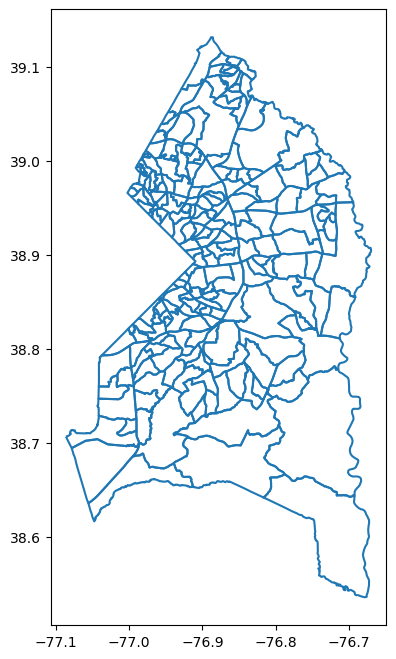

In [22]:
pg_county_agg.boundary.plot(figsize=(5, 8))

### Disaggregation/Downscaling - Inverse distance weighting technique

#### Polygon to Point Change of Support (the point is the target support)

In [23]:
centroids = pg_county.copy()
centroids['geometry'] = pg_county.geometry.centroid

In [24]:
centroid_coords = np.array([(point.x, point.y) for point in centroids.geometry])
centroid_values = centroids['median_income'].values

In [25]:
target_coords = np.array([(point.x, point.y) for point in clipped_pg.geometry])

In [26]:
# Function for IDW
def idw_interpolation(known_coords, known_values, target_coords, power=2):
    """
    Perform Inverse Distance Weighting (IDW) interpolation.
    
    Parameters:
    - known_coords: Array of known coordinates (x, y) of points with values.
    - known_values: Array of known values at each coordinate.
    - target_coords: Array of coordinates (x, y) where interpolation is desired.
    - power: The power parameter for IDW; typically 2.
    - epsilon: Small value added to distances to avoid division by zero.
    
    Returns:
    - interpolated_values: Array of interpolated values at target coordinates.
    """
    # Create KDTree for efficient distance calculations
    tree = cKDTree(known_coords)
    
    # Find distances from each target to the 15 nearest known points
    dists, idxs = tree.query(target_coords, k=15)
    
    # Inverse distance weighting calculation
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    
    # Weighted sum to estimate values at target points
    interpolated_values = np.sum(weights * known_values[idxs], axis=1)
    
    return interpolated_values

#### Still using the clipped points to census tract extents data from earlier.

In [27]:
pg_disagg = clipped_pg.copy()

#### Apply the IDW function

In [28]:
pg_disagg.loc[:,'estimated_income'] = idw_interpolation(centroid_coords, centroid_values, target_coords)

In [29]:
pg_disagg

,geometry,count,estimated_income
0,POINT (-76.82777 38.83870),3,89841.383396
3,POINT (-76.93079 38.75546),4,69452.915687
4,POINT (-76.78011 38.92195),5,121481.451111
5,POINT (-76.70045 38.67075),4,93497.781742
6,POINT (-76.91733 39.06203),3,115371.514276
...,...,...,...
1493,POINT (-76.90809 38.95287),2,96838.669824
1494,POINT (-76.70212 38.94567),3,75168.934577
1495,POINT (-76.90494 39.05638),1,89527.929558
1497,POINT (-76.73671 38.63032),5,128356.201606
